In [1]:
import os
import logging
import sys
import itertools
import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR
from vision.utils.misc import str2bool, Timer, freeze_net_layers, store_labels
from vision.ssd.ssd import MatchPrior
from vision.ssd.vgg_ssd import create_vgg_ssd

from vision.nn.multibox_loss import MultiboxLoss
from vision.ssd.config import vgg_ssd_config
from vision.ssd.data_preprocessing import TrainAugmentation, TestTransform

from road_datasets_day import RoadDamageDataset

import visdom
import pandas as pd
# viz = visdom.Visdom()

# def create_vis_plot(_xlabel, _ylabel, _title, _legend):
#     return viz.line(
#         X=torch.zeros((1,)).cpu(),
#         Y=torch.zeros((1, 3)).cpu(),
#         opts=dict(
#             xlabel=_xlabel,
#             ylabel=_ylabel,
#             title=_title,
#             legend=_legend
#         )
#     )
# def update_vis_plot(epoch, loc, conf, window, update_type,
#                     epoch_size=1):
#     viz.line(
#         X=torch.ones((1, 3)).cpu() * epoch,
#         Y=torch.Tensor([loc, conf, loc + conf]).unsqueeze(0).cpu(),
#         win=window,
#         update= update_type
#     )
    
# vis_train_title = 'Day SSD Train on RoadDamage'
# vis_test_title = 'Day SSD Test on RoadDamage'


# vis_legend = ['Loc Loss', 'Conf Loss', 'Total Loss']
# train_plot = create_vis_plot('Epoch', 'Loss', vis_train_title, vis_legend)
# test_plot = create_vis_plot('Epoch', 'Loss', vis_test_title, vis_legend)

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    torch.backends.cudnn.benchmark = True
    print("Use Cuda.")
    
def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train(True)
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    for i, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)  # TODO CHANGE BOXES
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        
        if i == len(loader)-1:
            plot_x.append(epoch)
            plot_y.append(loss.mean().item())
            
        if i and i % debug_steps == 0:
            avg_loss = running_loss / debug_steps
            avg_reg_loss = running_regression_loss / debug_steps
            avg_clf_loss = running_classification_loss / debug_steps
            
#             update_vis_plot(epoch, avg_reg_loss, avg_clf_loss,
#                              train_plot, 'append')
#             print(
#                 "Epoch: %d, Step: %d, Average Loss: %.4f, Average Regression Loss %.4f,Average Classification Loss: %.4f"
#                 % epoch,i,avg_loss,avg_reg_loss,avg_clf_loss
#             )
#             logging.info(
#                 f"Epoch: {epoch}, Step: {i}, " +
#                 f"Average Loss: {avg_loss:.4f}, " +
#                 f"Average Regression Loss {avg_reg_loss:.4f}, " +
#                 f"Average Classification Loss: {avg_clf_loss:.4f}"
#             )
            running_loss = 0.0
            running_regression_loss = 0.0
            running_classification_loss = 0.0
            
def test(loader, net, criterion, device):
    net.eval()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for _, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        num += 1

        with torch.no_grad():
            confidence, locations = net(images)
            regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
            loss = regression_loss + classification_loss

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
    return running_loss / num, running_regression_loss / num, running_classification_loss / num

Use Cuda.


In [3]:
create_net = create_vgg_ssd
config = vgg_ssd_config

train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                                  config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, config.image_std)


# Train data
datasets = []
datasets.append(RoadDamageDataset('/home/chiu/data/RoadDamage/data/', transform=train_transform,
                                 target_transform=target_transform))

# Val data
val_dataset = RoadDamageDataset('/home/chiu/data/RoadDamage/data/', transform=test_transform,
                                 target_transform=target_transform, is_test=True)

val_loader = DataLoader(val_dataset, 32,
                            num_workers=4,
                            shuffle=False)

num_classes = 9

train_dataset = ConcatDataset(datasets)

train_loader = DataLoader(train_dataset, 32,
                              num_workers=4,
                              shuffle=True)

net = create_net(num_classes)

base_net_lr = 1e-3

extra_layers_lr = 1e-3

params = [
            {'params': net.base_net.parameters(), 'lr': base_net_lr},
            {'params': itertools.chain(
                net.source_layer_add_ons.parameters(),
                net.extras.parameters()
            ), 'lr': extra_layers_lr},
            {'params': itertools.chain(
                net.regression_headers.parameters(),
                net.classification_headers.parameters()
            )}
        ]

net.to(DEVICE)

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                             center_variance=0.1, size_variance=0.2, device=DEVICE)
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9,
                                weight_decay=5e-4)

In [4]:
plot_x = []
plot_y = []
for epoch in range(0, 300):
    train(train_loader, net, criterion, optimizer,
        device=DEVICE, debug_steps=100, epoch=epoch)
        
    if epoch % 5 == 0 or epoch == 800 - 1:
        val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
#         update_vis_plot(epoch, val_regression_loss, val_classification_loss,
#                             test_plot, 'append')

        print(
                f"Epoch: {epoch}, " +
                f"Validation Loss: {val_loss:.4f}, " +
                f"Validation Regression Loss {val_regression_loss:.4f}, " +
                f"Validation Classification Loss: {val_classification_loss:.4f}"
        )
        model_path = os.path.join('checkpoint/day', f"VGG-Epoch-{epoch}.pth")
        net.save(model_path)
        
my_df = pd.DataFrame([plot_x,plot_y])
my_df.to_csv('out.csv', index=False, header=False)
print(my_df)

/data/anaconda/envs/neural/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0, Validation Loss: 10.7955, Validation Regression Loss 2.7136, Validation Classification Loss: 8.0819
Epoch: 5, Validation Loss: 5.9990, Validation Regression Loss 2.2599, Validation Classification Loss: 3.7390
Epoch: 10, Validation Loss: 5.7167, Validation Regression Loss 2.0988, Validation Classification Loss: 3.6180
Epoch: 15, Validation Loss: 5.5457, Validation Regression Loss 1.9991, Validation Classification Loss: 3.5465
Epoch: 20, Validation Loss: 5.4773, Validation Regression Loss 1.9578, Validation Classification Loss: 3.5196
Epoch: 25, Validation Loss: 5.3318, Validation Regression Loss 1.8527, Validation Classification Loss: 3.4791
Epoch: 30, Validation Loss: 5.2041, Validation Regression Loss 1.7782, Validation Classification Loss: 3.4259
Epoch: 35, Validation Loss: 5.1056, Validation Regression Loss 1.7342, Validation Classification Loss: 3.3714
Epoch: 40, Validation Loss: 5.0188, Validation Regression Loss 1.6987, Validation Classification Loss: 3.3201
Epoch: 45, 

Inference time:  0.01931166648864746


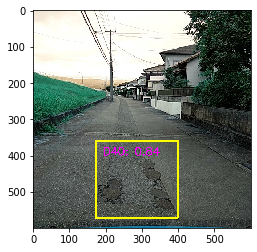

In [12]:
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
import cv2
from matplotlib import pyplot as plt

class_names = ['BACKGROUND','D00', 'D01', 'D10', 'D11',
            'D20', 'D40', 'D43', 'D44']

#image_path = '/home/chiu/data/RoadDamage/data/Nagakute/JPEGImages/Nagakute_20170907142957.jpg'
image_path = '/data/RoadDamage/data/Numazu/JPEGImages/Numazu_20170906135022.jpg'


net = create_vgg_ssd(len(class_names), is_test=True)

net.load('/home/chiu/data/pytorch-ssd/checkpoint/day/gmm/VGG-Epoch-370.pth')

predictor = create_vgg_ssd_predictor(net, candidate_size=200)

orig_image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)

boxes, labels, probs = predictor.predict(orig_image, 10, 0.4)

for i in range(boxes.size(0)):
    box = boxes[i, :]
    cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 4)
    #label = f"""{voc_dataset.class_names[labels[i]]}: {probs[i]:.2f}"""
    label = f"{class_names[labels[i]]}: {probs[i]:.2f}"
    cv2.putText(orig_image, label,
                (box[0] + 20, box[1] + 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,  # font scale
                (255, 0, 255),
                2)  # line type
plt.imshow(orig_image)
plt.savefig("d40.png")
plt.show()



DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


0.7722605876318874


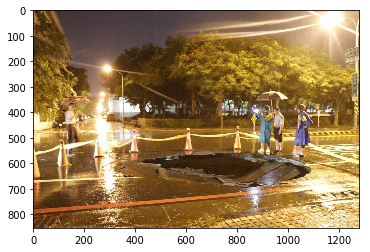

In [53]:
from PIL import Image

#img = Image.open(image_path)
img = Image.open('/home/chiu/Downloads/photo.jpeg')

#print(hls_image)
# lower_blue = np.array([0,0,0])
# upper_blue = np.array([255,150,255])

# mask = cv2.inRange(hls_image, lower_blue, upper_blue)

# res = cv2.bitwise_and(hls_image,hls_image, mask= mask)
h = img.size[0]
w = img.size[1]
percentage_dark = 0
thresh = 100
for x in range(img.size[0]):
    for y in range(img.size[1]):
        r,g,b = img.getpixel((x,y))
        if r < thresh or g < thresh or b < thresh:
            percentage_dark += 1
print(percentage_dark/(h*w))
plt.imshow(img)
plt.show()



In [1]:
import os
govs = ['Adachi', 'Chiba', 'Ichihara', 'Muroran', 'Nagakute', 'Sumida']

tmp = []
for gov in govs:
    
    f = open('/home/chiu/data/RoadDamage/data/' + gov + '/ImageSets/Main/val.txt','r')

    for line in f.readlines():
        line = line.strip()
        #print(line)
        #tmpline
        if os.path.isfile('/home/chiu/data/RoadDamage/data/' + gov + '/Annotations/' + line + '.xml') == False:
            print('/home/chiu/data/RoadDamage/data/' + gov + '/Annotations/' + line + '.xml')

        #tmp += '/home/chiu/data/RoadDamage/data/' + gov + '/Annotations/' + line + '.xml'
print(tmp)

[]
